<a href="https://colab.research.google.com/github/psaw/hse-ai24-ml/blob/main/KNN_versus_LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN с использованием LSH

## Импорт библиотек, установка константных значений

In [ ]:
import numpy as np

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

## Генерация данных

Для демонстрации сгенерируем датасет из нормального распределения, где $m$ - число объектов, $n$ - число признаков.

In [ ]:
m = 50000
n = 10000

$q$ - вектор запроса (query), для которого мы ищем ближайших соседей.

In [ ]:
X = rng.normal(size=(m, n))  # датасет
q = rng.normal(size=n)       # вектор запроса

## Поиск с помощью стандартного KNN

In [ ]:
def knn_search(query, data, k=5):

    dists = np.sqrt(np.sum((data - query) ** 2, axis=1))  # вычисляем расстояния от объекта query до всех точек датасета
    inds = np.argsort(dists)  # сортируем по возрастанию расстояний
    inds_k = inds[:k]         # берем top-k точек с наименьшими расстояниями

    return data[inds_k], dists[inds_k]

Найдем 5 ближайших соседей методом KNN.

Также замерим время работы поиска.

In [ ]:
%%time

neighbors, dists = knn_search(q, X)
for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 137.756240373655
top 2: dist = 138.09987299681939
top 3: dist = 138.19452917680704
top 4: dist = 138.22857049450062
top 5: dist = 138.2429317007995
CPU times: user 1.41 s, sys: 754 ms, total: 2.16 s
Wall time: 2.17 s


## KNN с использованием LSH

Идея метода состоит в том, что:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

Используем метод LSH с кодированием при помощи случайных проекций. Он состоит в следующем:
* проводим несколько случайных гиперплоскостей
* для каждой плоскости: для каждого объекта ставим 1, если объект лежит выше плоскости, и 0 иначе
* тогда каждый объект кодируется вектором из 0 и 1, где длина вектора равна числу сгенерированных гиперплоскостей

Объекты похожи, если их кодировки совпадают.

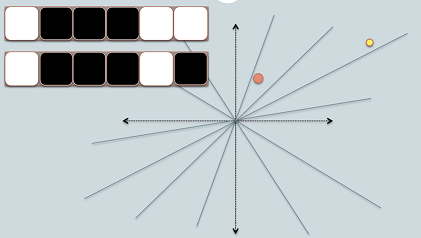

Следующая функция вычисляет количество случайных гиперплоскостей и генерирует их, основываясь на том, сколько в среднем мы хотим получать объектов в одной корзине после хеширования (`bucket_size`).

In [ ]:
def generate_hyperplanes(data, bucket_size=16):
    m = data.shape[0]            # число объектов
    n = data.shape[1]            # число признаков
    b = m // bucket_size         # количество корзин
    h = int(np.log2(b))          # количество гиперплоскостей
    H = rng.normal(size=(h, n))  # гиперплоскости, заданные своими нормалями
    return H

Следующая функция хеширует данные, основываясь на полученных гиперплоскостях, то есть кодирует объект вектором из 0 и 1.

Затем для удобства функция переводит вектор в число путем перевода из двоичной системы в десятичную.

Например: $[0, 1, 1, 0] \to 0 \cdot 1 + 1 \cdot 2 + 1 \cdot 4 + 0 \cdot 8 = 6$

Между двоичной и десятичной записью взаимно однозначное соответствие, но десятичная запись удобнее.  
По сути полученное число - это номер корзины, в которую попадает объект.

In [ ]:
def hamming_hash(data, hyperplanes):
    b = len(hyperplanes)
    hash_key = (data @ hyperplanes.T) >= 0

    dec_vals = np.array([2 ** i for i in range(b)], dtype=int)
    hash_key = hash_key @ dec_vals

    return hash_key

Теперь мы умеем по каждому объекту определять номер корзины, в которую он попадает.

Функция ниже создает словарь, где для каждой корзины содержатся элементы выборки, попадающие в эту корзину  
(эта структура называется *хеш-таблицей*).

In [ ]:
def locality_sensitive_hash(data, hyperplanes):
    hash_vals = hamming_hash(data, hyperplanes)
    hash_table = {}
    for i, v in enumerate(hash_vals):
        if v not in hash_table:
            hash_table[v] = set()
        hash_table[v].add(i)

    return hash_table

Посмотрим, как работают описанные функции.

In [ ]:
hyperplanes = generate_hyperplanes(X)

print('num planes:',len(hyperplanes))
print('normal vector to 1st plane:',hyperplanes[0])

num planes: 11
normal vector to 1st plane: [-0.85479774  1.70833663 -0.34637502 ...  0.09880598  1.01129995
 -1.73940005]


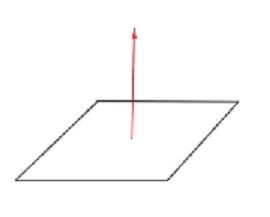

In [ ]:
hamming_hash(q, hyperplanes)

1221

In [ ]:
hash_table = locality_sensitive_hash(X, hyperplanes)
hash_table

{1885: {0,
  4753,
  9006,
  10544,
  11896,
  13519,
  14075,
  15891,
  16257,
  16587,
  17565,
  18758,
  20126,
  23463,
  24965,
  26799,
  27211,
  27613,
  27751,
  30955,
  35145,
  35596,
  39352,
  41158,
  43556,
  43603,
  43908,
  47045,
  47873},
 1976: {1,
  3324,
  6606,
  8717,
  16742,
  18730,
  22164,
  22817,
  24671,
  25207,
  27734,
  27996,
  29837,
  31242,
  35419,
  42339,
  44287,
  47267},
 288: {2,
  421,
  1241,
  3151,
  5016,
  6276,
  6422,
  8606,
  8934,
  9631,
  10637,
  11534,
  12397,
  27080,
  27505,
  28763,
  32084,
  32786,
  33596,
  33836,
  34124,
  35823,
  37868,
  38110,
  41332,
  45457},
 1783: {3,
  990,
  3064,
  8462,
  8733,
  9069,
  11091,
  11232,
  17954,
  19507,
  19613,
  23131,
  29477,
  31951,
  33208,
  34581,
  35123,
  35636,
  35837,
  42577,
  47260,
  48697},
 1144: {4,
  501,
  903,
  1157,
  4334,
  6622,
  7752,
  10215,
  12248,
  12294,
  13348,
  14559,
  21199,
  22100,
  22105,
  26263,
  31516,
  31683,

Теперь реализуем алгоритм поиска KNN с использованием LSH:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

In [ ]:
def approx_knn_search(query, data, k=5, bucket_size=16):
    candidates = set()

    hyperplanes = generate_hyperplanes(data)
    hash_table = locality_sensitive_hash(data, hyperplanes) # формируем хеш-таблицу по датасету

    query_hash = hamming_hash(query, hyperplanes)
    if query_hash in hash_table:
        candidates = candidates.union(hash_table[query_hash])
    candidates = np.stack([data[i] for i in candidates], axis=0) # находим кандидатов = объекты, попадающие с query в одну корзину

    return knn_search(query, candidates, k=k) # с помощью KNN ищем ближайших соседей только из найденных кандидатов

In [ ]:
%%time

neighbors, dists = approx_knn_search(q, X)

for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 139.87830415534592
top 2: dist = 139.9269850003241
top 3: dist = 140.06224062385834
top 4: dist = 140.24104537711904
top 5: dist = 140.48024515404026
CPU times: user 2.07 s, sys: 196 ms, total: 2.26 s
Wall time: 1.54 s
